In [11]:
import os
import re

import pandas as pd
import numpy as np
import plotnine as pn
import matplotlib.pyplot as plt

In [12]:
SUB_REGEX = re.compile("sub-[A-Za-z0-9]+")
SES_REGEX = re.compile("ses-[A-Za-z0-9]+")
TASK_REGEX = re.compile("task-[A-Za-z0-9]+")
RUN_REGEX = re.compile("run-[A-Za-z0-9]+")
DESC_REGEX = re.compile("desc-[A-Za-z0-9]+")

In [13]:
def split_entities(row):
    '''
    Given row x, construct entities
    '''
    
    def get_reg(reg, x):
        res = reg.search(x)
        return res[0] if res else np.nan
    
    x = row.entity
    sub_entities = (
        ("sub", get_reg(SUB_REGEX, x)),
        ("ses", get_reg(SES_REGEX, x)),
        ("task",get_reg(TASK_REGEX, x)),
        ("run",get_reg(RUN_REGEX, x)),
        ("desc",get_reg(DESC_REGEX, x))
    )
    
    for k,v in sub_entities:
        row[k] = v 
    return row

In [22]:
scratch = "/scratch/jjeyachandra/multiband-censoring-comparisons/"
f_qcfc = f"{scratch}/output/QCFC_results.parquet"

In [51]:
# Load and format data
cat_cols = ['source','target','method']
qcfc = pd.read_parquet(f_qcfc)\
        .astype({k: 'category' for k in cat_cols})\
        .dropna(axis=0)
qcfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140196 entries, 1 to 35148
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   source   140196 non-null  category
 1   target   140196 non-null  category
 2   pearson  140196 non-null  float64 
 3   pvalue   140196 non-null  float64 
 4   method   140196 non-null  category
dtypes: category(3), float64(2)
memory usage: 3.8 MB


### Analysis 1: Percent Edge significantly correlated with motion

In this analysis we compute pearson correlations between measured `framewise displacement` and `edge-FC`. Significance thresholding was done using `FDR` at $\alpha < 0.05$

In [52]:
import statsmodels.stats.multitest as stats_mc
from functools import partial

In [53]:
def fdr(g, alpha=0.05, method='fdr_bh'):
    '''
    Apply FDR correction to a pandas.Series p-value object
    '''
    res, _, _, _ = stats_mc.multipletests(g, alpha=alpha,
                                         method=method)
    return res

# Perform FDR on each method
qcfc['fdr'] = qcfc.groupby('method')['pvalue'].transform(fdr)

In [83]:
# Compute number of significant edges/group
sig_edges_by_group =\
    qcfc.groupby('method')\
        .apply(
            lambda x: 100*x.fdr.sum()/x.fdr.shape[0]
        )

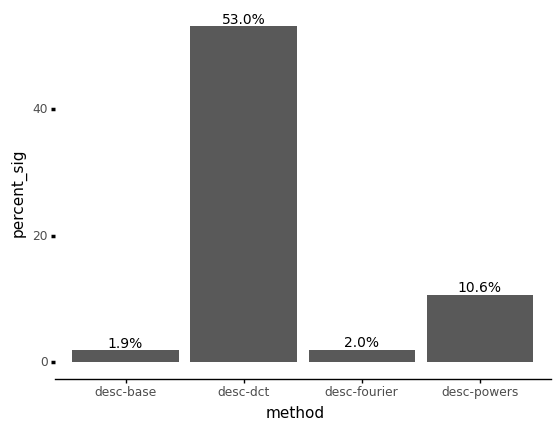

<ggplot: (8760753389279)>

In [124]:
viz_sig = pd.DataFrame(sig_edges_by_group,
                       columns=['percent_sig'])\
            .reset_index()

dodge_text = pn.position_dodge(width=0.0)

(pn.ggplot(viz_sig, pn.aes(x='method', y='percent_sig'))
    + pn.geom_col()
    + pn.geom_text(pn.aes(label='percent_sig'),
                size=10, va='bottom',
                format_string="{:.1f}%")
    + pn.theme(
        panel_background=pn.element_rect(fill='white'),
        axis_line_x=pn.element_line(color='black'),
        axis_ticks_major_y=pn.element_line(color='black',size=2.5)
    )
)  

### Analysis 2: Medial Correlation Value of Significant Edges

In this analysis we compute the median pearson $\rho$ correlation value for each of the censoring methods.

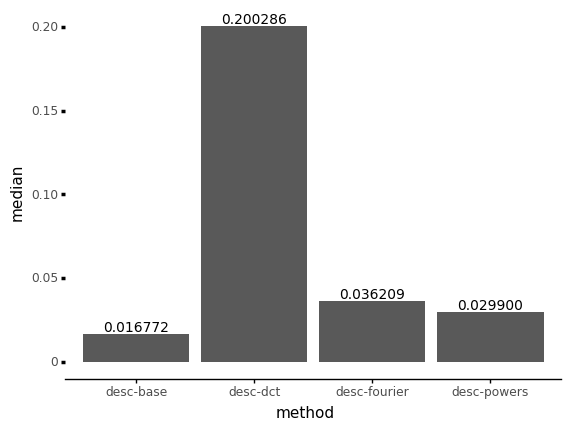

<ggplot: (8761037643337)>

In [176]:
median_df = qcfc.loc[:, ['method','pearson']]\
            .groupby('method')\
            .median()\
            .reset_index()\
            .rename(columns={'pearson':'median'})

(pn.ggplot(median_df, pn.aes(x='method', y='median'))
    + pn.geom_col()
    + pn.geom_text(pn.aes(label='median'),
                size=10, va='bottom',
                format_string="{:3f}")
    + pn.theme(
        panel_background=pn.element_rect(fill='white'),
        axis_line_x=pn.element_line(color='black'),
        axis_ticks_major_y=pn.element_line(color='black',size=2.5)
    )
)  

/projects/jjeyachandra/pyenv/versions/3.8.0/envs/power_censor/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 142'. Pick better value with 'binwidth'.


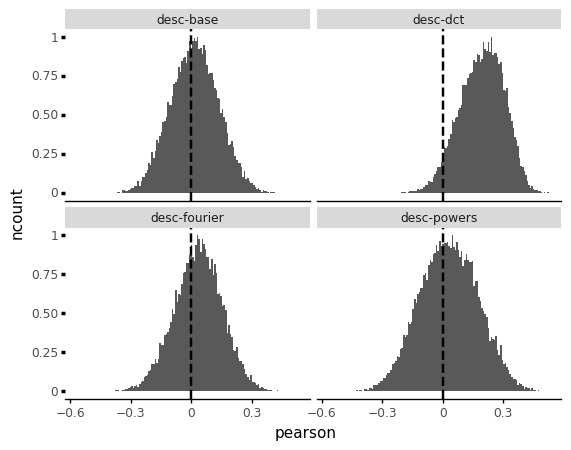

<ggplot: (8761037695973)>

In [179]:
(pn.ggplot(qcfc, pn.aes(x='pearson',
                        y=pn.after_stat('ncount')))
    + pn.geom_histogram()
    + pn.geom_vline(xintercept=0,
                    size=1,
                    linetype='dashed')
    + pn.theme(
        panel_background=pn.element_rect(fill='white'),
        axis_line_x=pn.element_line(color='black'),
        axis_ticks_major_y=pn.element_line(color='black',size=2.5)
    )
    + pn.facet_wrap(' ~ method')
)

### Analysis 3: Distance Dependent Relationship between Connectivity and Motion Artifact

In [180]:
# Need a distance matrix for parcellation